In [31]:
# using keras imdb dataset
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, concatenate, Flatten, SpatialDropout1D, Embedding, Dense, Dropout, Conv1D, GlobalMaxPool1D
from keras.callbacks import ModelCheckpoint
from keras.layers.wrappers import Bidirectional

import os
from sklearn.metrics import roc_auc_score

import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# set up params
output = 'model/dense_example'
epochs = 4
batch = 128

n_dim = 64
n_words = 5000
n_words_skip = 50
max_length = 200
pad_type = trunc_type = 'pre' # truncate start of reviews

n_conv1 = n_conv2 = n_conv3 = 256
kernel_1 = 3
kernel_2 = 2
kernel_3 = 4

n_dense = 64
dropout = 0.5

In [20]:
# load data
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=n_words, skip_top=n_words_skip)

In [21]:
x_train = pad_sequences(x_train, maxlen=max_length, padding=pad_type, truncating=trunc_type, value=0)
x_val = pad_sequences(x_val, maxlen=max_length, padding=pad_type, truncating=trunc_type, value=0)

In [36]:
input_layer = Input(shape=(max_length,), dtype='int16', name='input')

embedding_layer = Embedding(n_words, n_dim, input_length=max_length, name='embedding')(input_layer)
drop_embed_layer = SpatialDropout1D(dropout, name='drop_embed')(embedding_layer)

conv_1 = Conv1D(n_conv1, kernel_1, activation='relu', name='conv1')(drop_embed_layer)
maxpool_1 = GlobalMaxPool1D(name='maxpool1')(conv_1)

conv_2 = Conv1D(n_conv2, kernel_2, activation='relu', name='conv2')(drop_embed_layer)
maxpool_2 = GlobalMaxPool1D(name='maxpool2')(conv_2)

conv_3 = Conv1D(n_conv3, kernel_3, activation='relu', name='conv3')(drop_embed_layer)
maxpool_3 = GlobalMaxPool1D(name='maxpool3')(conv_3)

concat = concatenate([maxpool_1, maxpool_2, maxpool_3])

dense1 = Dense(n_dense, activation='relu', name='dense1')(concat)
drop_dense1 = Dropout(dropout, name='dropout_dense1')(dense1)

dense2 = Dense(n_dense, activation='relu', name='dense2')(drop_dense1)
drop_dense2 = Dropout(dropout, name='dropout_dense2')(dense2)

output = Dense(1, activation='sigmoid', name='output')(drop_dense2)

model = Model(input_layer, output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 200)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 64)      320000      input[0][0]                      
__________________________________________________________________________________________________
drop_embed (SpatialDropout1D)   (None, 200, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 198, 256)     49408       drop_embed[0][0]                 
__________________________________________________________________________________________________
conv2 (Con

In [38]:
model.fit(
    x_train, 
    y_train,
    epochs=epochs, 
    batch_size=batch, 
    verbose=1, 
    validation_data=(x_val, y_val))

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 114s 5ms/step - loss: 0.6545 - acc: 0.5848 - val_loss: 0.4717 - val_acc: 0.7970
Epoch 2/4
25000/25000 [==============================] - 110s 4ms/step - loss: 0.4426 - acc: 0.7933 - val_loss: 0.3559 - val_acc: 0.8526
Epoch 3/4
25000/25000 [==============================] - 132s 5ms/step - loss: 0.3590 - acc: 0.8467 - val_loss: 0.3349 - val_acc: 0.8562
Epoch 4/4
25000/25000 [==============================] - 103s 4ms/step - loss: 0.3163 - acc: 0.8658 - val_loss: 0.3242 - val_acc: 0.8640


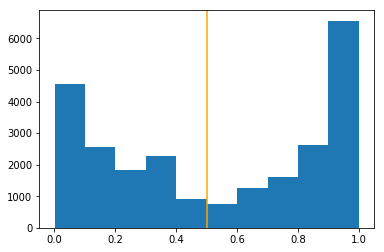

In [39]:
plt.hist(model.predict(x_val))
_ = plt.axvline(x=0.5, color='orange')